<a href="https://colab.research.google.com/github/DrPaulaEkene/Binary_Classification_Of_Uterine-Myoma_ltrasound_Via_ResNet50_And_MobileNet/blob/main/Final_Project_Uterine_Myoma_(Uterine_fibroids)_Ultrasound_image_classification_with_ResNet50_and_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook focuses on the Comparative Analysis of Deep Learning Architectures for Uterine Myoma Classification: Custom ResNet50 vs. Mobile NetV2**

*Import all needed libraries*

In [1]:
# Make all necessary imports
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image

In [2]:
# Import the drive module
from google.colab import drive

# Mount the Google Drive to the Colab environment.
drive.mount('/content/drive')

Mounted at /content/drive


Exploratory data analysis

In [ ]:
# Create the data file paths/directories
# Define the base directory
data_directory = "/content/drive/MyDrive/UF_dataset"

# Define directories for training and testing data
train_directory = "/content/drive/MyDrive/UF_dataset/train"
test_directory = "/content/drive/MyDrive/UF_dataset/test"

In [ ]:
# Print the contents of the base directory

# Function to print contents of a directory
def print_directory_contents(directory, subdirs):
    for subdir in subdirs:
        subdir_path = os.path.join(directory, subdir)
        if os.path.exists(subdir_path):
            print(f"\nContents of {subdir_path}:")
            for item in os.listdir(subdir_path):
                print(item)
        else:
            print(f"\n{subdir_path} does not exist.")

print("Contents of the base directory:")
print(os.listdir(data_directory))

# Print the contents of the training directory
print("\nContents of the training directory:")
print(os.listdir(train_directory))
print_directory_contents(train_directory, ['NUF', 'UF'])

# Print the contents of the testing directory
print("\nContents of the testing directory:")
print(os.listdir(test_directory))
print_directory_contents(test_directory, ['NUF', 'UF'])


Contents of the base directory:
['1.2.826.0.1.3680043.2.461.11301518.1849713856.jpg', '1.2.826.0.1.3680043.2.461.11301519.531737451.jpg', '1.2.826.0.1.3680043.2.461.11301521.1331253811.jpg', '1.2.826.0.1.3680043.2.461.11301521.250905338.jpg', '1.2.826.0.1.3680043.2.461.11301521.704960520.jpg', '1.2.826.0.1.3680043.2.461.11301521.1865503937.jpg', '1.2.826.0.1.3680043.2.461.11301521.4216844312.jpg', '1.2.826.0.1.3680043.2.461.11301522.742552078.jpg', '1.2.826.0.1.3680043.2.461.11301522.2857734559.jpg', '1.2.826.0.1.3680043.2.461.11301522.1372347287.jpg', '1.2.826.0.1.3680043.2.461.11301521.2436177613.jpg', '1.2.826.0.1.3680043.2.461.11301520.2658168329.jpg', '1.2.826.0.1.3680043.2.461.11301522.913479745.jpg', '1.2.826.0.1.3680043.2.461.11301525.2220413095.jpg', '1.2.826.0.1.3680043.2.461.11301523.1653786924.jpg', '1.2.826.0.1.3680043.2.461.11301523.2948715458.jpg', '1.2.826.0.1.3680043.2.461.11301524.2960341954.jpg', '1.2.826.0.1.3680043.2.461.11301525.2072747749.jpg', '1.2.826.0.1.36800

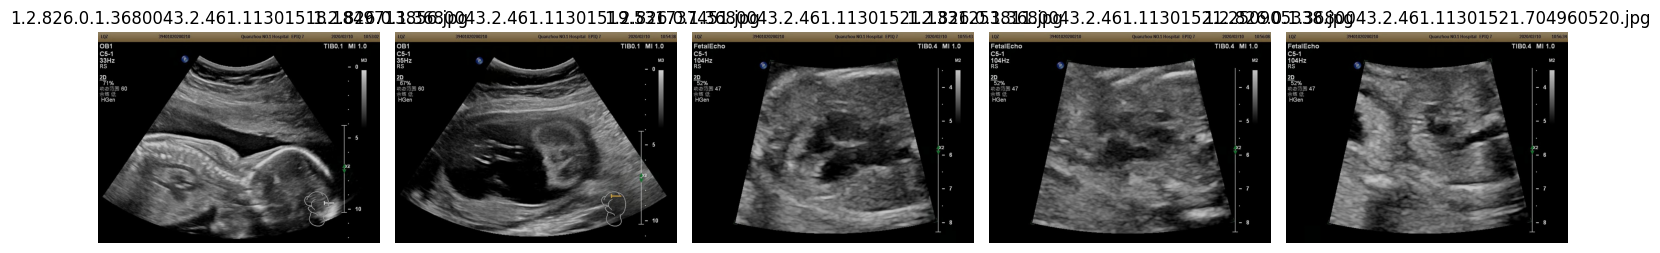

In [ ]:
# Plot 5 images from each directory
import os
import matplotlib.pyplot as plt
from PIL import Image


def plot_images(directory):
    # Get the list of files in the directory
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))] # Filter out directories

    # Plot up to 5 images from the directory
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    axes = axes.flatten()

    for i, file in enumerate(files[:5]):
        # Load the image
        img_path = os.path.join(directory, file)
        img = Image.open(img_path)

        # Plot the image
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(file)

    plt.tight_layout()
    plt.show()

# Plot 5 images from the data directory
plot_images(data_directory)

In [ ]:
from collections import defaultdict
import numpy as np

def get_image_shapes(directory):
    shapes = defaultdict(int)
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                with Image.open(img_path) as img:
                    shapes[img.size] += 1
    return shapes

train_shapes = get_image_shapes(train_directory)
test_shapes = get_image_shapes(test_directory)

print("Training set image shapes:", dict(train_shapes))
print("Testing set image shapes:", dict(test_shapes))


Training set image shapes: {(1024, 768): 1576, (1138, 846): 61, (1028, 796): 105, (1026, 766): 2, (1020, 772): 19, (768, 576): 15, (1022, 786): 1, (994, 766): 1, (720, 576): 6, (1920, 1080): 2, (1136, 852): 3, (704, 666): 2, (730, 666): 1, (1160, 844): 1, (1280, 872): 4, (1034, 794): 5}
Testing set image shapes: {(1024, 768): 370, (720, 576): 2, (768, 552): 1, (1020, 772): 1, (804, 632): 1, (1028, 796): 6, (1138, 846): 15}


Preprocessing with imageDataGenerator

Image classification with ResNet

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define directories
data_directory = "/content/drive/MyDrive/UF_dataset"
train_directory = "/content/drive/MyDrive/UF_dataset/train"
test_directory = "/content/drive/MyDrive/UF_dataset/test"

# Create an ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from directory
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Load pre-trained ResNet50 model (without top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation='sigmoid')(x)

# Create model
model1 = tf.keras.Model(inputs=base_model.input, outputs=x)

# Compile model
model1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model1.summary()

# Train the model
historyRes = model1.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator
)

# Evaluate the model
loss, accuracy = model1.evaluate(test_generator)
print(f'ResNet50 Test Accuracy: {accuracy:.2f}')


Found 1804 images belonging to 2 classes.
Found 396 images belonging to 2 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 59s 755ms/step - accuracy: 0.5194 - loss: 0.6956 - val_accuracy: 0.6465 - val_loss: 0.6550
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 461ms/step - accuracy: 0.5921 - loss: 0.6651 - val_accuracy: 0.7980 - val_loss: 0.6086
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 467ms/step - accuracy: 0.7215 - loss: 0.6362 - val_accuracy: 0.8359 - val_loss: 0.5626
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 471ms/step - accuracy: 0.7064 - loss: 0.6128 - val_accuracy: 0.8207 - val_loss: 0.5465
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 483ms/step - accuracy: 0.7434 - loss: 0.5996 - val_accuracy: 0.8384 - val_loss: 0.5099
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 480ms/step - accuracy: 0.6792 - loss: 0.6004 - val_accuracy: 0.8157 - val_loss: 0.5132
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 483ms/step - accuracy: 0.7187 - loss: 0.5920 - val_accuracy: 0.8333 - val_loss: 0.4785
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 482ms/step - accuracy: 0.7173 - loss: 0.5835 - val_accuracy: 0.825

In [ ]:
# Evaluate the Custom ResNet Model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import tensorflow as tf

def evaluate_model(model, test_generator, class_labels):
    """
    Evaluate the model on test data and print various metrics.

    Parameters:
    - model: The trained Keras model.
    - test_generator: Keras ImageDataGenerator for test data.
    - class_labels: List of class labels.
    """
    # Get true labels and predictions
    y_true = test_generator.classes
    y_pred_prob = model.predict(test_generator, verbose=1)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Compute metrics
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = recall_score(y_true, y_pred)  # Recall
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    harmonic_mean = (2 * precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

    # Print metrics
    print(f'Sensitivity (Recall): {sensitivity:.2f}')
    print(f'Specificity: {specificity:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print(f'Harmonic Mean of Precision and Recall: {harmonic_mean:.2f}')

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(model, test_generator, class_labels, title="Confusion Matrix"):
    """
    Plots the confusion matrix for a given model and test data.

    Parameters:
    - model: Trained model to evaluate.
    - test_generator: The generator for the test data.
    - class_labels: List of class labels for the confusion matrix axes.
    - title: Title of the plot.
    """
    # Predict the classes
    y_pred_prob = model.predict(test_generator, verbose=1)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Get the true labels
    y_true = test_generator.classes

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='cividis', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

evaluate_model(model1, test_generator, ['NUF', 'UF'])

21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 337ms/step
Sensitivity (Recall): 0.75
Specificity: 0.22
Precision: 0.48
F1 Score: 0.59
Harmonic Mean of Precision and Recall: 0.59


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step


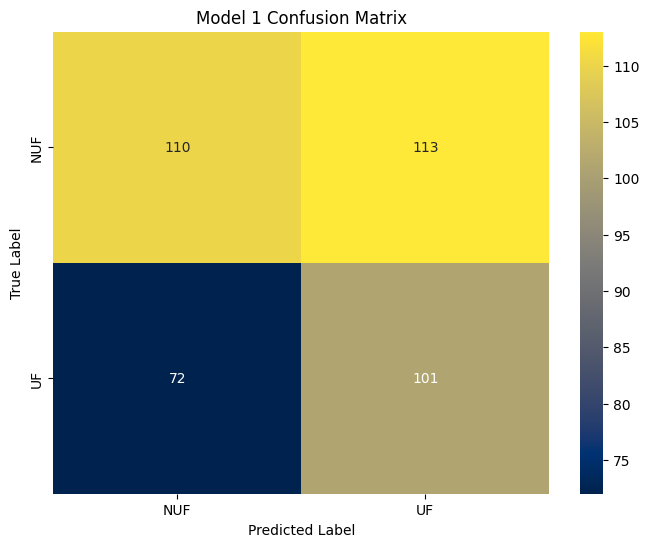

In [ ]:
plot_confusion_matrix(model1, test_generator, ['NUF', 'UF'],title="Model 1 Confusion Matrix")

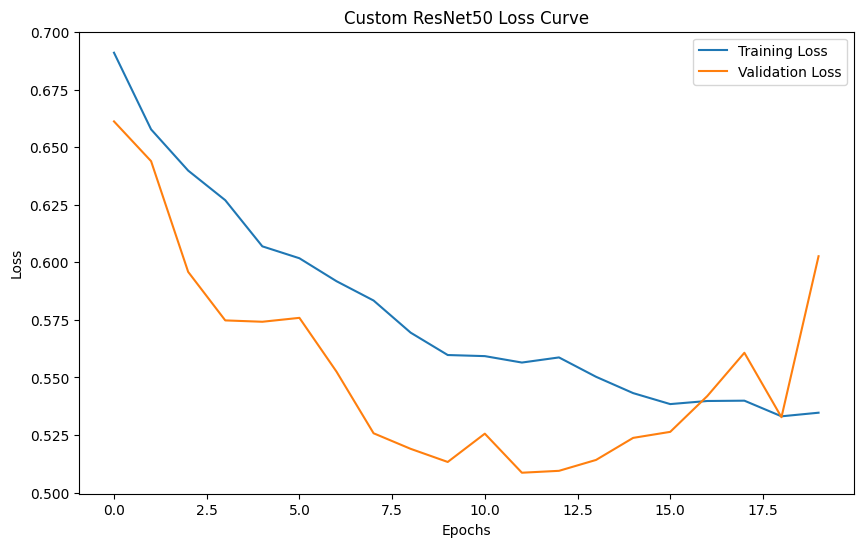

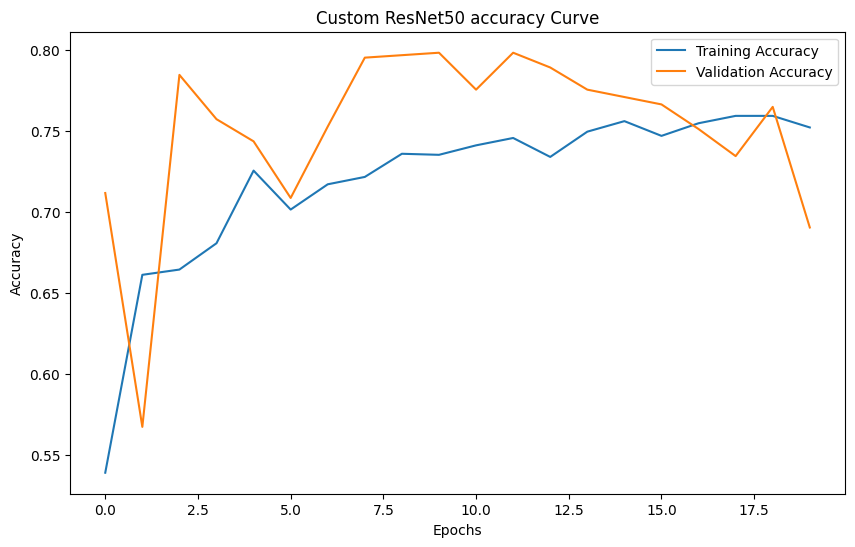

In [ ]:
# Function to plot loss curve
def plot_loss_curve(history, title='Training and Validation Loss'):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Function to plot accuracy curve with a customizable title
def plot_accuracy_curve(history, title='Training and Validation Accuracy'):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot loss and accuracy curves
plot_loss_curve(historyRes, title='Custom ResNet50 Loss Curve')
plot_accuracy_curve(historyRes,title='Custom ResNet50 accuracy Curve' )

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback

# Define a custom callback to monitor accuracy
class BestAccuracyCallback(Callback):
    def __init__(self):
        super(BestAccuracyCallback, self).__init__()
        self.best_accuracy = 0

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get("val_accuracy")
        if current_accuracy and current_accuracy > self.best_accuracy:
            self.best_accuracy = current_accuracy
            print(f"New Best Accuracy: {self.best_accuracy:.4f}")

# Instantiate the custom callback
best_accuracy_callback = BestAccuracyCallback()

# Add 10 more epochs and train the model
historyRes = model1.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=[best_accuracy_callback]  # Include the custom callback
)


Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.8044 - loss: 0.4637 - precision: 0.8461 - recall: 0.7492New Best Accuracy: 0.8283
57/57 ━━━━━━━━━━━━━━━━━━━━ 32s 494ms/step - accuracy: 0.8041 - loss: 0.4640 - precision: 0.8456 - recall: 0.7490 - val_accuracy: 0.8283 - val_loss: 0.4387 - val_precision: 0.7536 - val_recall: 0.9017
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 32s 489ms/step - accuracy: 0.7840 - loss: 0.4713 - precision: 0.8320 - recall: 0.7013 - val_accuracy: 0.7803 - val_loss: 0.4805 - val_precision: 0.6853 - val_recall: 0.9191
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 477ms/step - accuracy: 0.7882 - loss: 0.4716 - precision: 0.8302 - recall: 0.7236 - val_accuracy: 0.8005 - val_loss: 0.4673 - val_precision: 0.7098 - val_recall: 0.9191
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 490ms/step - accuracy: 0.7976 - loss: 0.4662 - precision: 0.8294 - recall: 0.7642 - val_accuracy: 0.7677 - val_loss: 0.4947 - val_precision: 0.6709 - val_recall: 0.9191
Epoch 5/30
57/57 ━━

In [ ]:
# Evaluate the model, model1
metrics = model1.evaluate(test_generator)
loss = metrics[0]
accuracy = metrics[1]
print(f'ResNet50 Test Accuracy: {accuracy:.2f}')
print(f'Best Validation Accuracy During Training: {best_accuracy_callback.best_accuracy:.4f}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step - accuracy: 0.7950 - loss: 0.4727 - precision: 0.6974 - recall: 0.9142
ResNet50 Test Accuracy: 0.81
Best Validation Accuracy During Training: 0.8384


In [ ]:
evaluate_model(model1, test_generator, ['NUF', 'UF'])

13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 427ms/step
Sensitivity (Recall): 0.60
Specificity: 0.49
Precision: 0.48
F1 Score: 0.53
Harmonic Mean of Precision and Recall: 0.53


**Modify the model further for better results**

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step


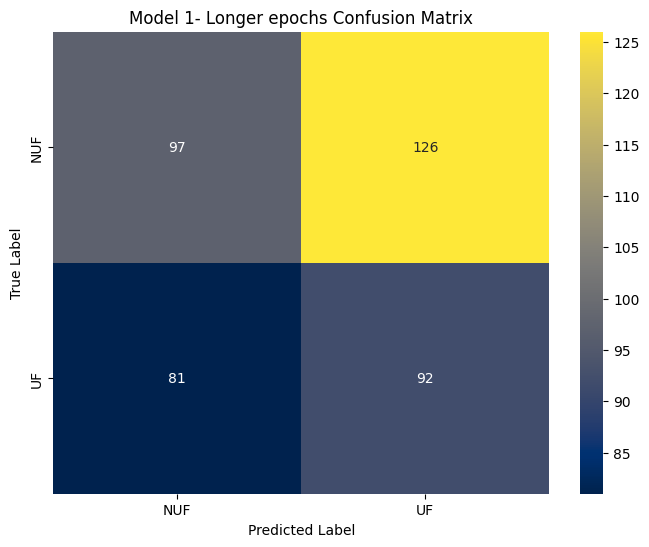

In [ ]:
# Evaluate model1 again
plot_confusion_matrix(model1, test_generator, ['NUF', 'UF'],title="Model 1- Longer epochs Confusion Matrix")

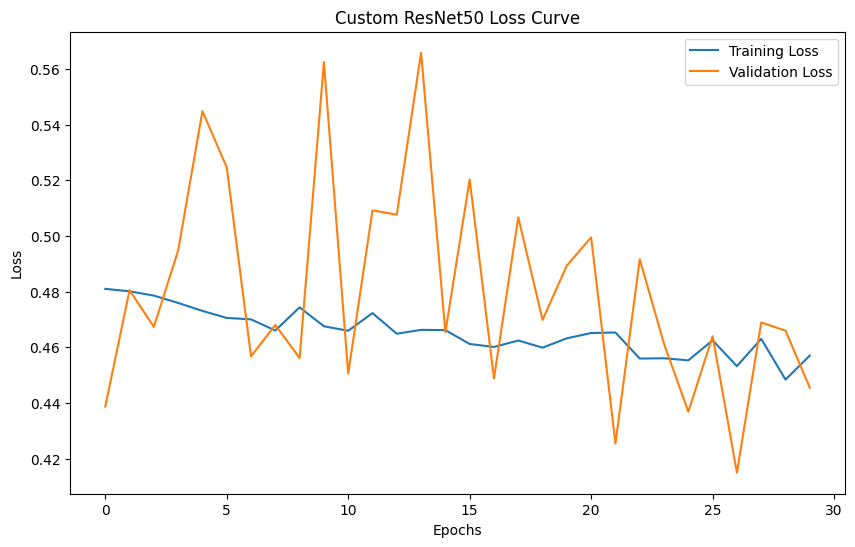

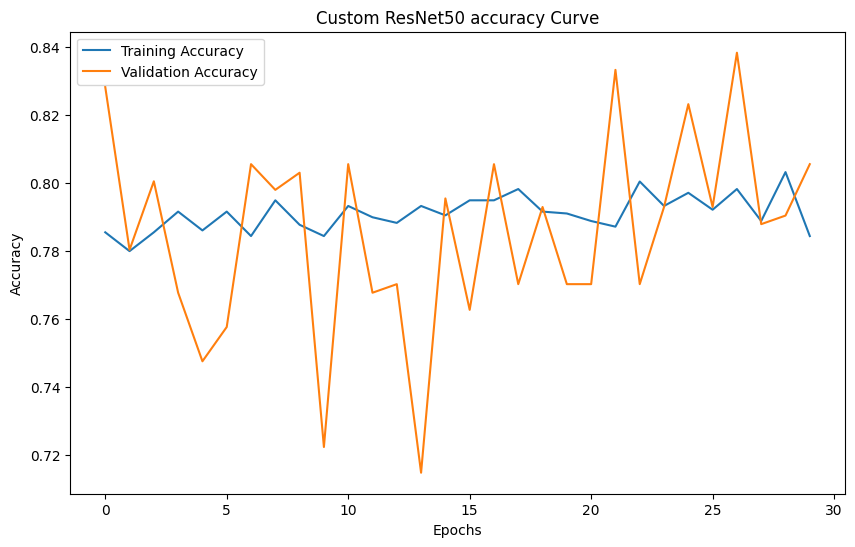

In [ ]:
# Plot loss and accuracy curves
plot_loss_curve(historyRes, title='Custom ResNet50 Loss Curve')
plot_accuracy_curve(historyRes,title='Custom ResNet50 accuracy Curve' )

In [ ]:
# Unfreeze layers, Model1b

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load ResNet50 without the top (classification) layer
resnet_with_top = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the top layers (last 10) of the model
for layer in resnet_with_top.layers[-10:]:
    layer.trainable = True

# Add a custom head for binary classification - UF and NUF
model1b = Sequential([
    resnet_with_top,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model1b.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
history_with_top = model1b.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
loss, accuracy = model1b.evaluate(test_generator)
print(f'ResNet50 with Top Layer Test Accuracy: {accuracy:.2f}')

NameError: name 'ReduceLROnPlateau' is not defined

In [ ]:
evaluate_model(model1b, test_generator, ['NUF', 'UF'])

13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 426ms/step
Sensitivity (Recall): 0.08
Specificity: 0.96
Precision: 0.58
F1 Score: 0.14
Harmonic Mean of Precision and Recall: 0.14


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step


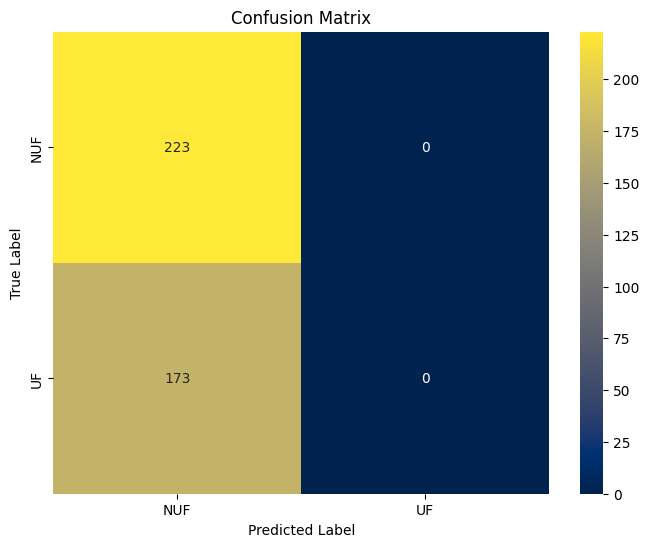

In [ ]:
plot_confusion_matrix(model1b, test_generator, ['NUF', 'UF'])

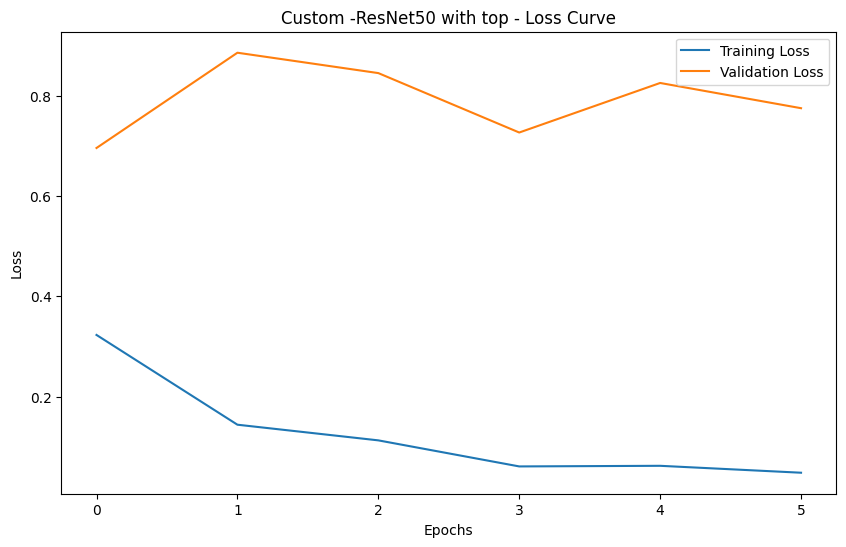

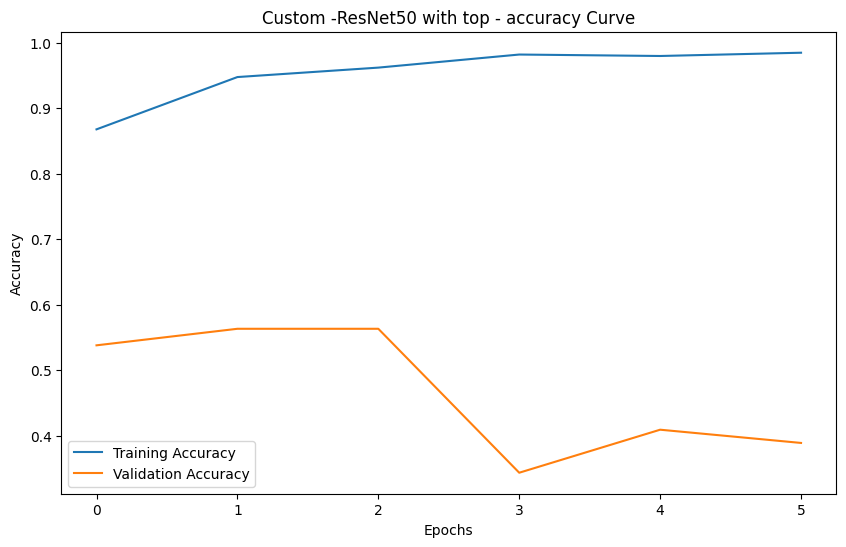

In [ ]:
# Plot loss and accuracy curves
plot_loss_curve(history_with_top, title='Custom -ResNet50 with top - Loss Curve')
plot_accuracy_curve(history_with_top,title='Custom -ResNet50 with top - accuracy Curve' )

Add more layers

In [ ]:
# Increase nodes by 50%
# Load pre-trained ResNet50 model (without top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# Create model
model1c = tf.keras.Model(inputs=base_model.input, outputs=x)

# Compile model
model1c.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model1c.summary()

# Train the model
historyRes_layers = model1c.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
loss, accuracy = model1c.evaluate(test_generator)
print(f'ResNet50layers Test Accuracy: {accuracy:.2f}')

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,801,153 (94.61 MB)

 Trainable params: 1,213,441 (4.63 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 48s 607ms/step - accuracy: 0.4821 - loss: 0.8149 - val_accuracy: 0.5732 - val_loss: 0.6756 - learning_rate: 0.0010
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 481ms/step - accuracy: 0.5137 - loss: 0.7088 - val_accuracy: 0.7652 - val_loss: 0.6840 - learning_rate: 0.0010
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 473ms/step - accuracy: 0.5295 - loss: 0.6945 - val_accuracy: 0.8409 - val_loss: 0.6619 - learning_rate: 0.0010
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 481ms/step - accuracy: 0.5684 - loss: 0.6758 - val_accuracy: 0.6263 - val_loss: 0.6281 - learning_rate: 0.0010
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 480ms/step - accuracy: 0.6059 - loss: 0.6632 - val_accuracy: 0.5783 - val_loss: 0.6159 - learning_rate: 0.0010
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 486ms/step - accuracy: 0.6356 - loss: 0.6388 - val_accuracy: 0.8359 - val_loss: 0.4781 - learning_rate: 0.0010
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 479ms/step - accuracy: 0.6925 - loss: 0.

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step
Sensitivity (Recall): 0.51
Specificity: 0.49
Precision: 0.44
F1 Score: 0.47
Harmonic Mean of Precision and Recall: 0.47
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step


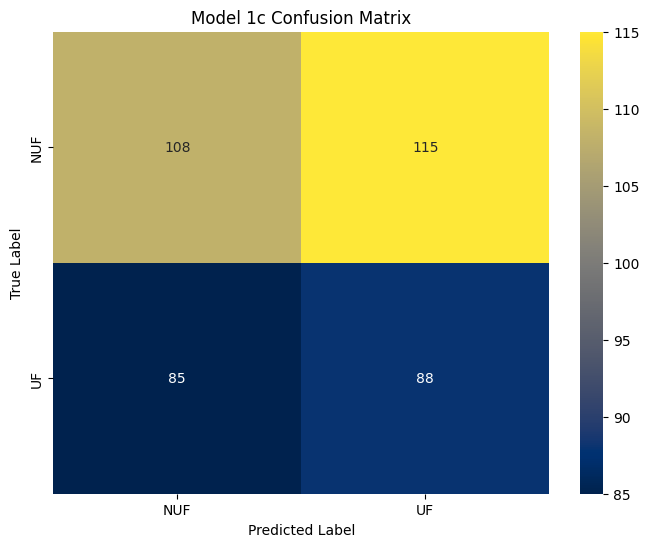

In [ ]:
# Evaluate model1c
evaluate_model(model1c, test_generator, ['NUF', 'UF'])
plot_confusion_matrix(model1c, test_generator, ['NUF', 'UF'],title="Model 1c Confusion Matrix")

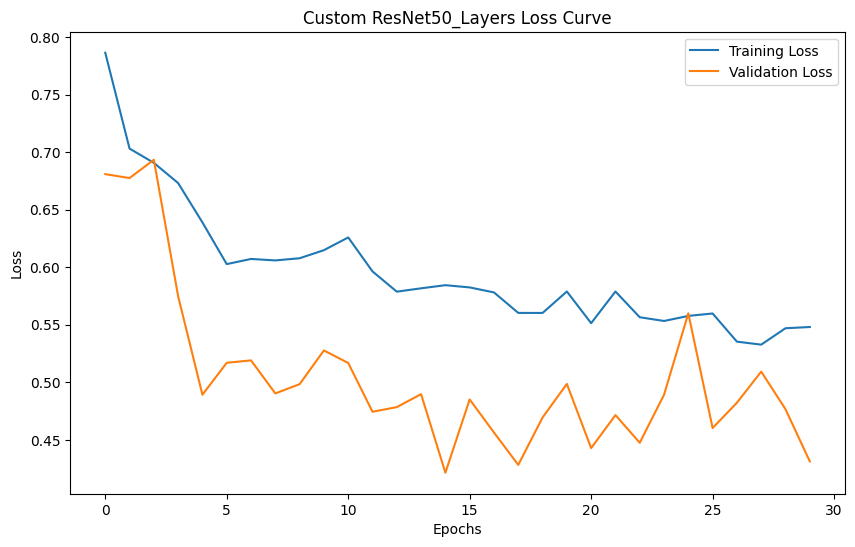

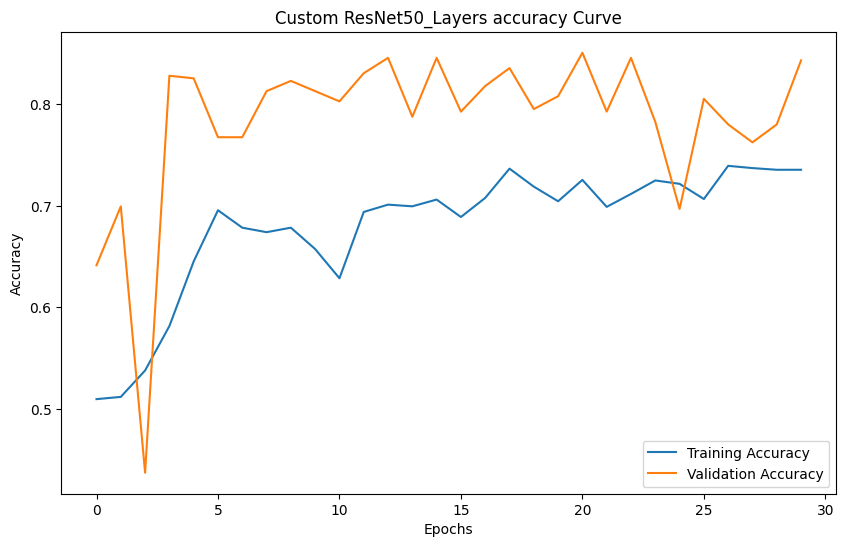

In [ ]:
# Plot loss and accuracy curves
plot_loss_curve(historyRes_layers, title='Custom ResNet50_Layers Loss Curve')
plot_accuracy_curve(historyRes_layers, title='Custom ResNet50_Layers accuracy Curve')

In [ ]:
# Increase patience levels
#  Adjust the learning rate when the validation loss stops improving


base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# Create model
model1d = tf.keras.Model(inputs=base_model.input, outputs=x)

# Compile model
model1d.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001
)

# Set up EarlyStopping and ModelCheckpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model with callback
historyRes_layer_Lr = model1d.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[reduce_lr, early_stopping, checkpoint]
)

# Evaluate the model
model1d.load_weights('best_model.keras')
loss, accuracy = model1d.evaluate(test_generator)
print(f'ResNet50_Layer Test Accuracy: {accuracy:.2f}')


Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 49s 626ms/step - accuracy: 0.4993 - loss: 0.8639 - val_accuracy: 0.4369 - val_loss: 0.6886 - learning_rate: 0.0010
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 478ms/step - accuracy: 0.5129 - loss: 0.7127 - val_accuracy: 0.5631 - val_loss: 0.6748 - learning_rate: 0.0010
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 464ms/step - accuracy: 0.5232 - loss: 0.7041 - val_accuracy: 0.8283 - val_loss: 0.6765 - learning_rate: 0.0010
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 483ms/step - accuracy: 0.5082 - loss: 0.7070 - val_accuracy: 0.6566 - val_loss: 0.6738 - learning_rate: 0.0010
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 484ms/step - accuracy: 0.5373 - loss: 0.6860 - val_accuracy: 0.8056 - val_loss: 0.6540 - learning_rate: 0.0010
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 483ms/step - accuracy: 0.5919 - loss: 0.6668 - val_accuracy: 0.7197 - val_loss: 0.5824 - learning_rate: 0.0010
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 32s 489ms/step - accuracy: 0.6301 - loss: 0.

13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 414ms/step
Sensitivity (Recall): 0.42
Specificity: 0.54
Precision: 0.41
F1 Score: 0.41
Harmonic Mean of Precision and Recall: 0.41
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step


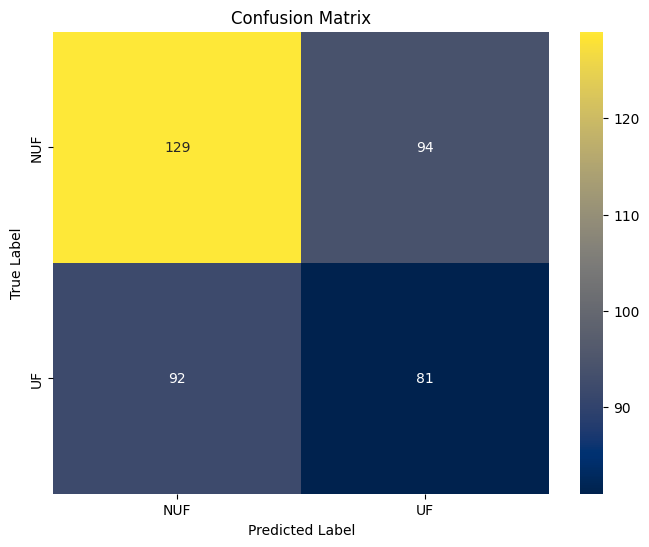

In [ ]:
evaluate_model(model1d, test_generator, ['NUF', 'UF'])
plot_confusion_matrix(model1d, test_generator, ['NUF', 'UF'])

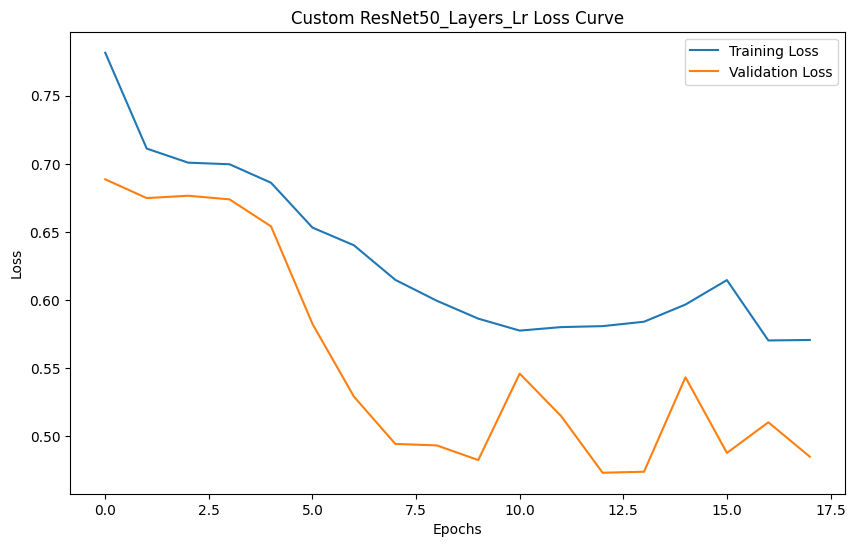

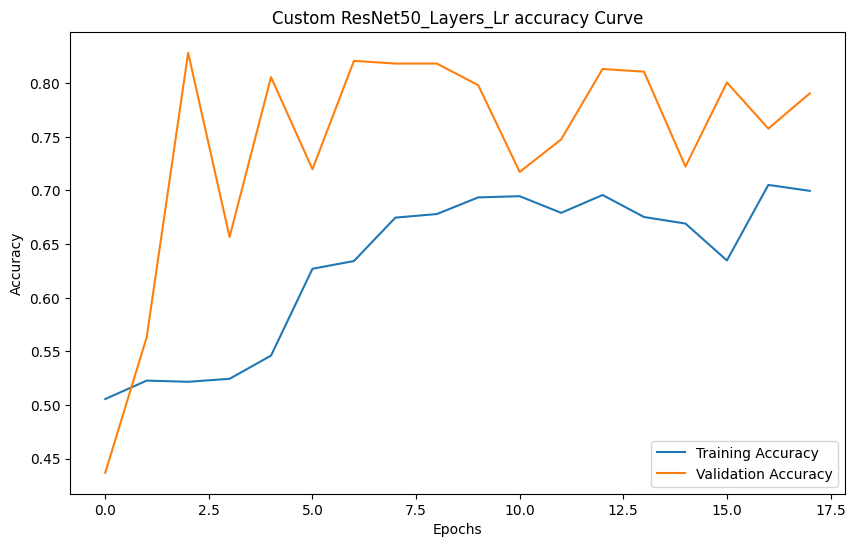

In [ ]:
# Plot loss and accuracy curves
plot_loss_curve(historyRes_layer_Lr, title='Custom ResNet50_Layers_Lr Loss Curve')
plot_accuracy_curve(historyRes_layer_Lr, title='Custom ResNet50_Layers_Lr accuracy Curve')

In [ ]:
# Balance classes and train with best model so far
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Balance class and train with the model with the highest accuracy so far
class_names = ['NUF', 'UF']
class_indices = train_generator.class_indices

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=list(class_indices.values()),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))

# Set up EarlyStopping and ModelCheckpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

In [ ]:
# Train the model with class weights and callbacks
history_class_bal = model1d.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 41s 533ms/step - accuracy: 0.6949 - loss: 0.5571 - val_accuracy: 0.8485 - val_loss: 0.4984
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 487ms/step - accuracy: 0.6436 - loss: 0.6111 - val_accuracy: 0.8535 - val_loss: 0.4588
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 467ms/step - accuracy: 0.6729 - loss: 0.5929 - val_accuracy: 0.8535 - val_loss: 0.4838
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 466ms/step - accuracy: 0.6748 - loss: 0.5912 - val_accuracy: 0.7879 - val_loss: 0.5217
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 479ms/step - accuracy: 0.7128 - loss: 0.5849 - val_accuracy: 0.8485 - val_loss: 0.4662


In [ ]:
# Evaluate the model using the best saved model
model1d.load_weights('best_model.keras')
loss, accuracy = model1d.evaluate(test_generator)
print(f'ResNet50_Class_Balance Test Accuracy: {accuracy:.2f}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.8602 - loss: 0.4601
ResNet50_Class_Balance Test Accuracy: 0.85


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step
Sensitivity (Recall): 0.57
Specificity: 0.47
Precision: 0.45
F1 Score: 0.51
Harmonic Mean of Precision and Recall: 0.51
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step


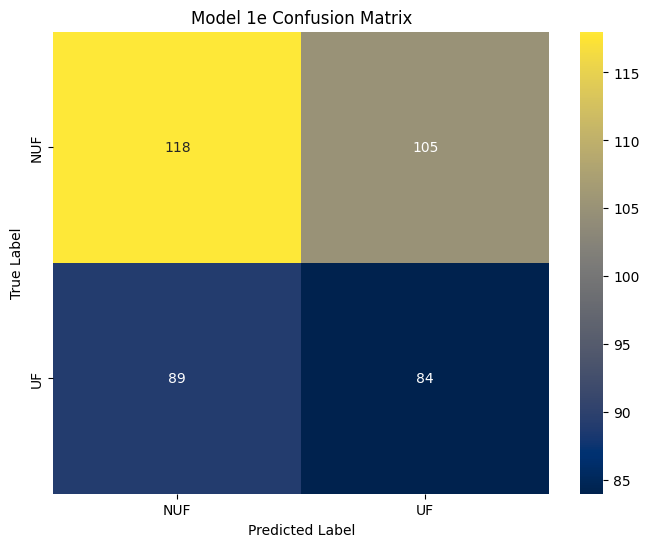

In [ ]:
evaluate_model(model1, test_generator, ['NUF', 'UF'])
plot_confusion_matrix(model1d, test_generator, ['NUF', 'UF'],title="Model 1e Confusion Matrix")

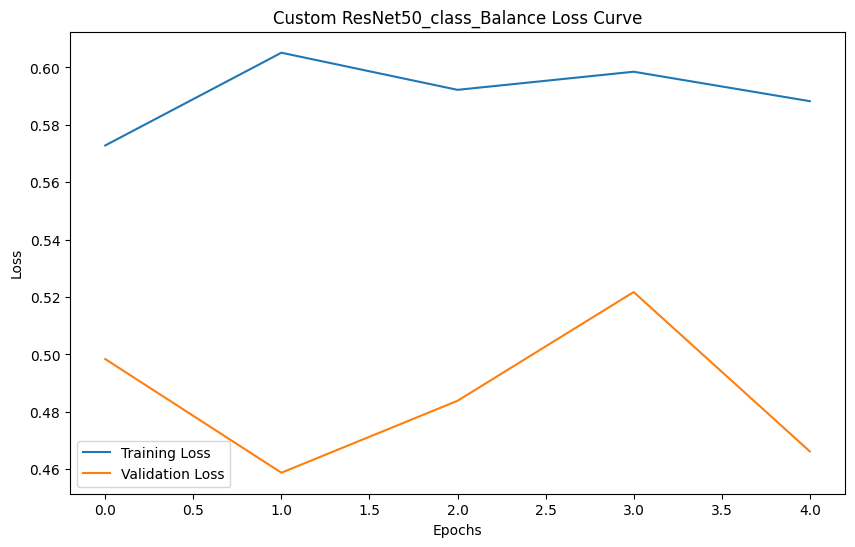

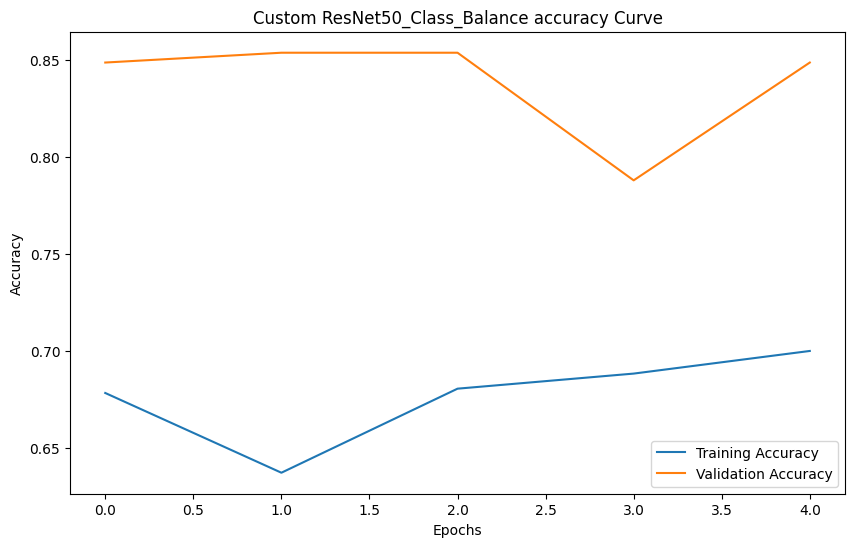

In [ ]:
# Plot loss and accuracy curves
plot_loss_curve(history_class_bal, title='Custom ResNet50_class_Balance Loss Curve')
plot_accuracy_curve(history_class_bal,title='Custom ResNet50_Class_Balance accuracy Curve' )


In [ ]:
# Train the model with class weights and callbacks
history_class_bal = model1d.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    class_weight=class_weight_dict,
    callbacks=[checkpoint]
)


Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 486ms/step - accuracy: 0.6731 - loss: 0.5681 - val_accuracy: 0.8333 - val_loss: 0.5018
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 468ms/step - accuracy: 0.6689 - loss: 0.5895 - val_accuracy: 0.7374 - val_loss: 0.5335
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 469ms/step - accuracy: 0.6910 - loss: 0.5753 - val_accuracy: 0.8005 - val_loss: 0.4930
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 475ms/step - accuracy: 0.7147 - loss: 0.5705 - val_accuracy: 0.7045 - val_loss: 0.5457
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 460ms/step - accuracy: 0.7299 - loss: 0.5508 - val_accuracy: 0.7247 - val_loss: 0.5512
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 473ms/step - accuracy: 0.6742 - loss: 0.5976 - val_accuracy: 0.8510 - val_loss: 0.4946
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 466ms/step - accuracy: 0.6792 - loss: 0.5912 - val_accuracy: 0.8106 - val_loss: 0.4834
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 472ms/step - accuracy: 0.6929 - loss: 0.5889 - val_accu

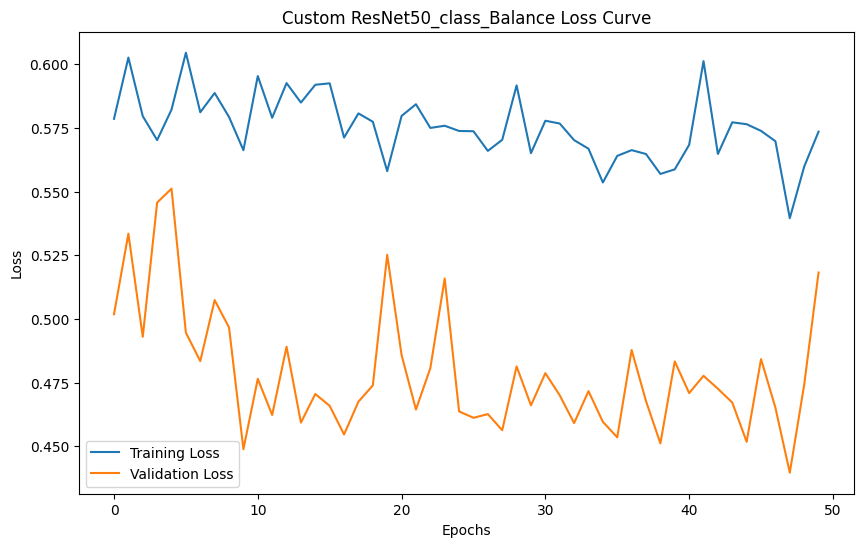

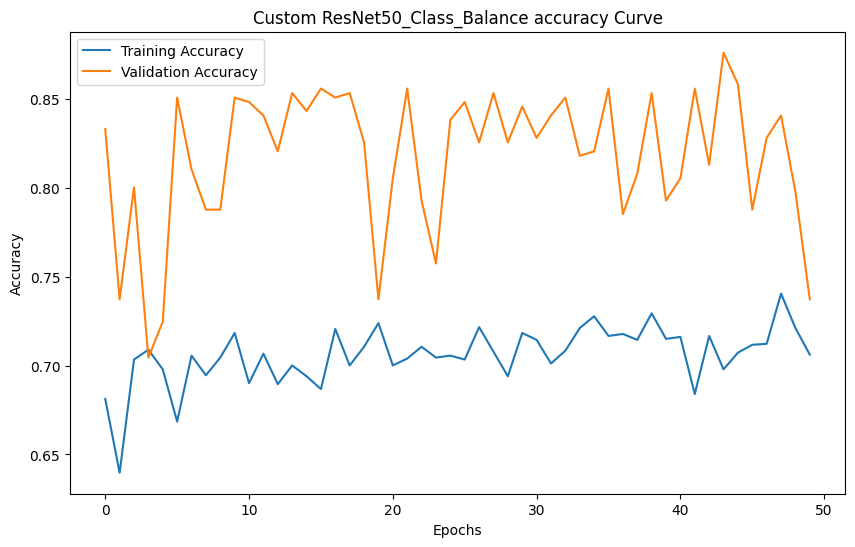

In [ ]:
# Plot loss and accuracy curves
plot_loss_curve(history_class_bal, title='Custom ResNet50_class_Balance Loss Curve')
plot_accuracy_curve(history_class_bal,title='Custom ResNet50_Class_Balance accuracy Curve' )

Initiate MobileNet

In [ ]:
# Make all necessary imports
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 1804 images belonging to 2 classes.
Found 396 images belonging to 2 classes.


In [ ]:
# Load MobileNetV3 Large model without the top layer
mobilenet_v3_base = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in mobilenet_v3_base.layers:
    layer.trainable = False

# Add custom layers on top
model_with_top = Sequential([
    mobilenet_v3_base,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Compile the model
model_with_top.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

In [ ]:
# Train the model
historyMob = model_with_top.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 54s 668ms/step - accuracy: 0.5256 - loss: 0.7229 - val_accuracy: 0.8460 - val_loss: 0.6617
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 481ms/step - accuracy: 0.5295 - loss: 0.7144 - val_accuracy: 0.8308 - val_loss: 0.6398
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 474ms/step - accuracy: 0.5686 - loss: 0.6891 - val_accuracy: 0.8712 - val_loss: 0.6146
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 481ms/step - accuracy: 0.5830 - loss: 0.6742 - val_accuracy: 0.8763 - val_loss: 0.5936
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 476ms/step - accuracy: 0.5739 - loss: 0.6794 - val_accuracy: 0.8409 - val_loss: 0.5864
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 469ms/step - accuracy: 0.5827 - loss: 0.6672 - val_accuracy: 0.7727 - val_loss: 0.5831
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 469ms/step - accuracy: 0.6395 - loss: 0.6400 - val_accuracy: 0.8359 - val_loss: 0.5593
Epoch 8/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 464ms/step - accuracy: 0.6407 - loss: 0.6387 - val_accuracy: 0.762

In [ ]:
# Evaluate the model on the test data
loss, accuracy = model_with_top.evaluate(test_generator)
print(f'MobileNetV3 Large with Custom Enhancements Test Accuracy: {accuracy:.2f}')


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step - accuracy: 0.8582 - loss: 0.4676
MobileNetV3 Large with Custom Enhancements Test Accuracy: 0.86


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step
Sensitivity (Recall): 0.50
Specificity: 0.43
Precision: 0.41
F1 Score: 0.45
Harmonic Mean of Precision and Recall: 0.45
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step


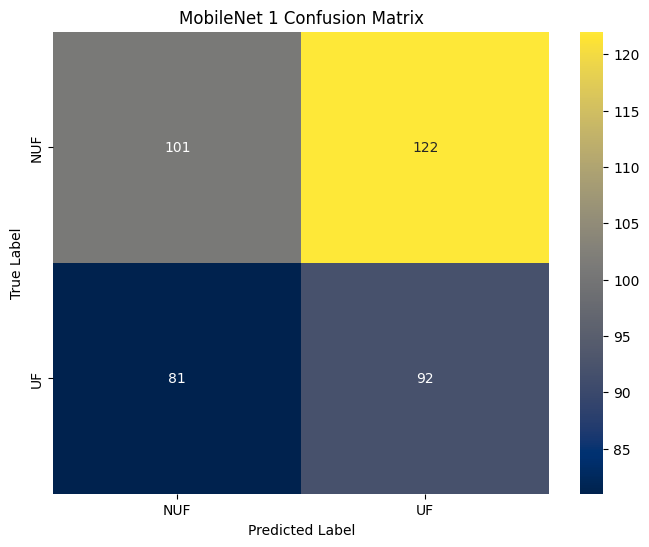

In [ ]:
evaluate_model(model_with_top, test_generator, ['NUF', 'UF'])

plot_confusion_matrix(model_with_top, test_generator, ['NUF', 'UF'],title="MobileNet 1 Confusion Matrix")


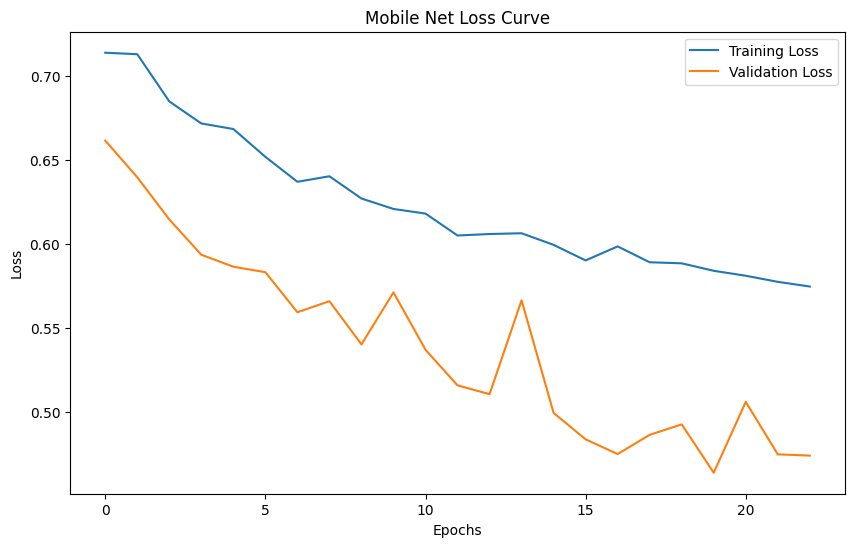

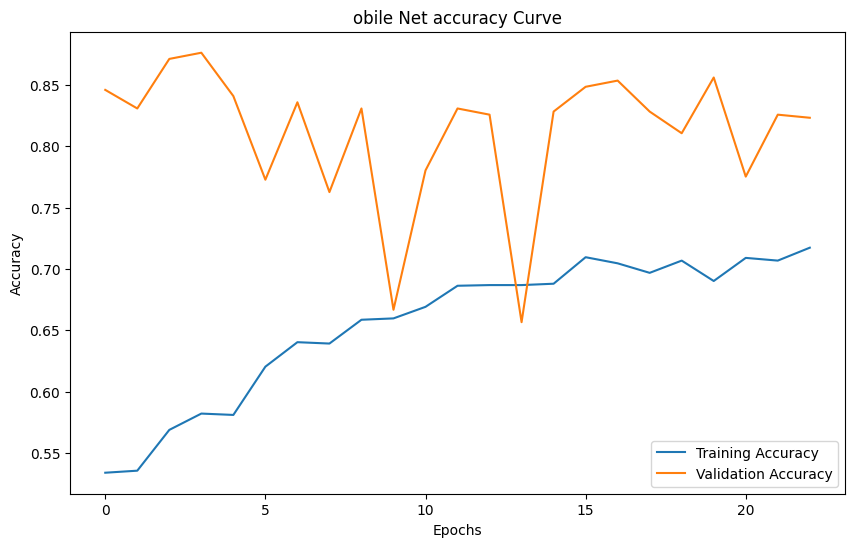

In [ ]:
# Plot loss and accuracy curves
plot_loss_curve(historyMob, title='Mobile Net Loss Curve')
plot_accuracy_curve(historyMob,title='obile Net accuracy Curve' )

In [ ]:
# Increase model complexity gradually
MobileNet2 = Sequential([
    mobilenet_v3_base,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
MobileNet2.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

In [ ]:
# Train the model
historyMob_morcomplex = MobileNet2.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 51s 656ms/step - accuracy: 0.5167 - loss: 0.7341 - val_accuracy: 0.5808 - val_loss: 0.6867
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 484ms/step - accuracy: 0.5191 - loss: 0.7133 - val_accuracy: 0.7980 - val_loss: 0.6731
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 478ms/step - accuracy: 0.4890 - loss: 0.7216 - val_accuracy: 0.8434 - val_loss: 0.6677
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 483ms/step - accuracy: 0.5296 - loss: 0.7002 - val_accuracy: 0.8788 - val_loss: 0.6635
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 471ms/step - accuracy: 0.5451 - loss: 0.6863 - val_accuracy: 0.8586 - val_loss: 0.6555
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 475ms/step - accuracy: 0.5369 - loss: 0.6922 - val_accuracy: 0.8434 - val_loss: 0.6430
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 470ms/step - accuracy: 0.5612 - loss: 0.6831 - val_accuracy: 0.8889 - val_loss: 0.6380
Epoch 8/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 468ms/step - accuracy: 0.5835 - loss: 0.6729 - val_accu

In [ ]:
# Evaluate the model on the test data
loss, accuracy = MobileNet2.evaluate(test_generator)
print(f'MobileNetV3 Large with Custom Enhancements Test Accuracy: {accuracy:.2f}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.8353 - loss: 0.4462
MobileNetV3 Large with Custom Enhancements Test Accuracy: 0.86


13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 484ms/step
Sensitivity (Recall): 0.57
Specificity: 0.52
Precision: 0.48
F1 Score: 0.52
Harmonic Mean of Precision and Recall: 0.52
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step


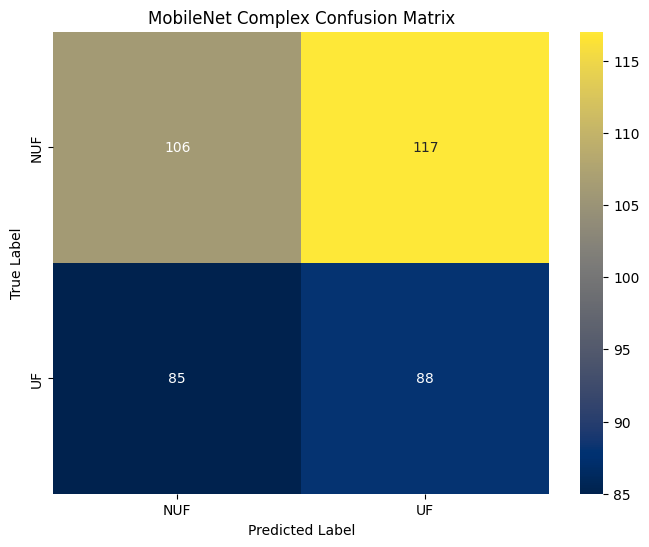

In [ ]:
evaluate_model(MobileNet2, test_generator, ['NUF', 'UF'])
plot_confusion_matrix(MobileNet2, test_generator, ['NUF', 'UF'],title="MobileNet Complex Confusion Matrix")

In [ ]:
# resplit into 70:30 and try with the best models, while balancing the dataset

import os
import shutil
import random
from math import ceil


In [ ]:
import os
import shutil
import random
from math import ceil

# Define directories
train_directory = "/content/drive/MyDrive/UF_dataset/train"
test_directory = "/content/drive/MyDrive/UF_dataset/test"

# List classes
classes = os.listdir(train_directory)

for cls in classes:
    train_class_dir = os.path.join(train_directory, cls)
    test_class_dir = os.path.join(test_directory, cls)

    # List all files
    train_files = os.listdir(train_class_dir)
    test_files = os.listdir(test_class_dir)

    total_files = len(train_files) + len(test_files)
    target_train_count = ceil(total_files * 0.7)
    current_train_count = len(train_files)
    files_to_move = current_train_count - target_train_count

    if files_to_move > 0:
        files_to_move = random.sample(train_files, files_to_move)

        for file_name in files_to_move:
            source = os.path.join(train_class_dir, file_name)
            destination = os.path.join(test_class_dir, file_name)
            shutil.move(source, destination)

    elif files_to_move < 0:
        files_to_move = random.sample(test_files, -files_to_move)

        for file_name in files_to_move:
            source = os.path.join(test_class_dir, file_name)
            destination = os.path.join(train_class_dir, file_name)
            shutil.move(source, destination)

# Verify the new split
for cls in classes:
    train_class_dir = os.path.join(train_directory, cls)
    test_class_dir = os.path.join(test_directory, cls)

    train_count = len(os.listdir(train_class_dir))
    test_count = len(os.listdir(test_class_dir))

    print(f"Class: {cls}, Train: {train_count}, Test: {test_count}, Ratio: {train_count / (train_count + test_count):.2f}")


Class: NUF, Train: 788, Test: 337, Ratio: 0.70
Class: UF, Train: 753, Test: 322, Ratio: 0.70


In [ ]:
# Train again with the first model
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define directories
data_directory = "/content/drive/MyDrive/UF_dataset"
train_directory = "/content/drive/MyDrive/UF_dataset/train"
test_directory = "/content/drive/MyDrive/UF_dataset/test"

# Create an ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from directory
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Load pre-trained ResNet50 model (without top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation='sigmoid')(x)

# Create model
model1 = tf.keras.Model(inputs=base_model.input, outputs=x)

# Compile model
model1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model1.summary()

# Train the model
historyRes = model1.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator
)

# Evaluate the model
loss, accuracy = model1.evaluate(test_generator)
print(f'ResNet50 Test Accuracy: {accuracy:.2f}')


Found 1541 images belonging to 2 classes.
Found 659 images belonging to 2 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


49/49 ━━━━━━━━━━━━━━━━━━━━ 1194s 22s/step - accuracy: 0.5250 - loss: 0.7027 - val_accuracy: 0.7117 - val_loss: 0.6612
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 509ms/step - accuracy: 0.6556 - loss: 0.6654 - val_accuracy: 0.5675 - val_loss: 0.6439
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 501ms/step - accuracy: 0.6339 - loss: 0.6443 - val_accuracy: 0.7845 - val_loss: 0.5958
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 499ms/step - accuracy: 0.6536 - loss: 0.6344 - val_accuracy: 0.7572 - val_loss: 0.5748
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 517ms/step - accuracy: 0.7205 - loss: 0.6094 - val_accuracy: 0.7436 - val_loss: 0.5742
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 495ms/step - accuracy: 0.7212 - loss: 0.6047 - val_accuracy: 0.7086 - val_loss: 0.5759
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 503ms/step - accuracy: 0.7167 - loss: 0.5930 - val_accuracy: 0.7527 - val_loss: 0.5525
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 493ms/step - accuracy: 0.7179 - loss: 0.5871 - val_accuracy: 0.795

In [ ]:
# icrease epochs and introduce dropout

# Compile model
model1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model1.summary()

# Set up EarlyStopping and ModelCheckpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Train the model with callback
historyRes_layer_Lr = model1.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

# Evaluate the model
loss, accuracy = model1.evaluate(test_generator)
print(f'ResNet50 Test Accuracy: {accuracy:.2f}')


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 42s 618ms/step - accuracy: 0.7575 - loss: 0.5102 - val_accuracy: 0.7693 - val_loss: 0.5276
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 499ms/step - accuracy: 0.7568 - loss: 0.5325 - val_accuracy: 0.7845 - val_loss: 0.5031
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 504ms/step - accuracy: 0.7579 - loss: 0.5251 - val_accuracy: 0.7876 - val_loss: 0.5054
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 495ms/step - accuracy: 0.7573 - loss: 0.5210 - val_accuracy: 0.7769 - val_loss: 0.5212
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 499ms/step - accuracy: 0.7795 - loss: 0.5157 - val_accuracy: 0.7800 - val_loss: 0.5172
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 504ms/step - accuracy: 0.7677 - loss: 0.5153 - val_accuracy: 0.7906 - val_loss: 0.5066
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 497ms/step - accuracy: 0.7686 - loss: 0.5140 - val_accuracy: 0.8149 - val_loss: 0.4695
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 500ms/step - accuracy: 0.7542 - loss: 0.5162 - val_accu

Define A Generative Adversarial Network and combine with Mobile Net

In [5]:
# Necessary Imports
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2D, BatchNormalization, Activation, UpSampling2D, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import os

# Define directories
data_directory = "/content/drive/MyDrive/UF_dataset"
train_directory = "/content/drive/MyDrive/UF_dataset/train"
test_directory = "/content/drive/MyDrive/UF_dataset/test"

# Data Augmentation using ImageDataGenerator with additional augmentation techniques
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Load MobileNetV3 Large model without the top layer
mobilenet_v3_base = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in mobilenet_v3_base.layers:
    layer.trainable = False

# DCAN (Dense Convolutional Attention Network) Block
# DCAN (Dense Convolutional Attention Network) Block
def DCAN_block(input_tensor):
    x = Conv2D(256, (3, 3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Attention Mechanism
    attention = Conv2D(256, (1, 1), activation='sigmoid')(x)
    x = x * attention

    #No need to upsample
    #x = UpSampling2D(size=(2, 2))(x)
    x = Concatenate()([input_tensor, x])

    return x

Found 1541 images belonging to 2 classes.
Found 659 images belonging to 2 classes.


In [6]:
# Apply DCAN block on the MobileNetV3 base model
dcan_output = DCAN_block(mobilenet_v3_base.output)

# Global Average Pooling and Classification layers
x = GlobalAveragePooling2D()(dcan_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# Create the final model
model_with_dcan = Model(inputs=mobilenet_v3_base.input, outputs=x)

# Compile the model
model_with_dcan.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
checkpoint = ModelCheckpoint('best_mobilenet_dcan_model.keras', monitor='val_loss', save_best_only=True)

In [7]:
# Train the model
history = model_with_dcan.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


49/49 ━━━━━━━━━━━━━━━━━━━━ 1771s 32s/step - accuracy: 0.5440 - loss: 0.6966 - val_accuracy: 0.5281 - val_loss: 0.6600 - learning_rate: 1.0000e-04
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 543ms/step - accuracy: 0.6852 - loss: 0.5988 - val_accuracy: 0.6085 - val_loss: 0.6086 - learning_rate: 1.0000e-04
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 545ms/step - accuracy: 0.7139 - loss: 0.5602 - val_accuracy: 0.6722 - val_loss: 0.5764 - learning_rate: 1.0000e-04
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 543ms/step - accuracy: 0.7196 - loss: 0.5730 - val_accuracy: 0.6950 - val_loss: 0.5543 - learning_rate: 1.0000e-04
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 555ms/step - accuracy: 0.7447 - loss: 0.5265 - val_accuracy: 0.8392 - val_loss: 0.5022 - learning_rate: 1.0000e-04
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 540ms/step - accuracy: 0.7302 - loss: 0.5619 - val_accuracy: 0.8452 - val_loss: 0.4596 - learning_rate: 1.0000e-04
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 29s 526ms/step - accuracy: 0.72

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - accuracy: 0.8387 - loss: 0.4603
MobileNetV3 with DCAN Test Accuracy: 0.85


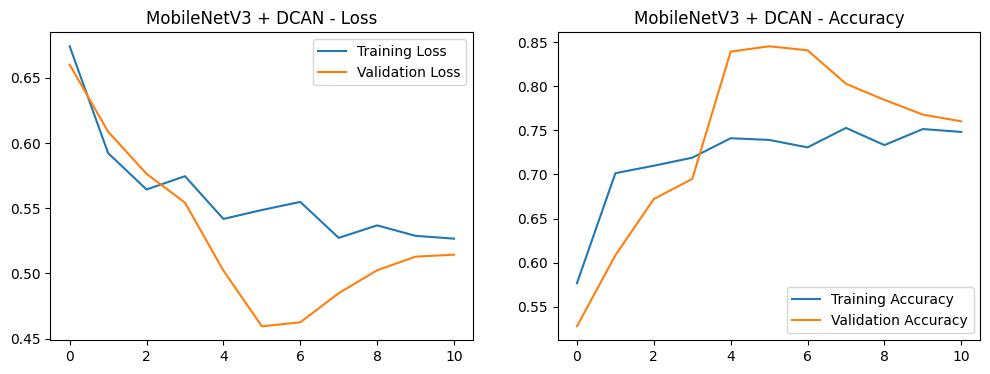

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.8541 - loss: 0.4566
MobileNetV3 with DCAN Test Accuracy: 0.85


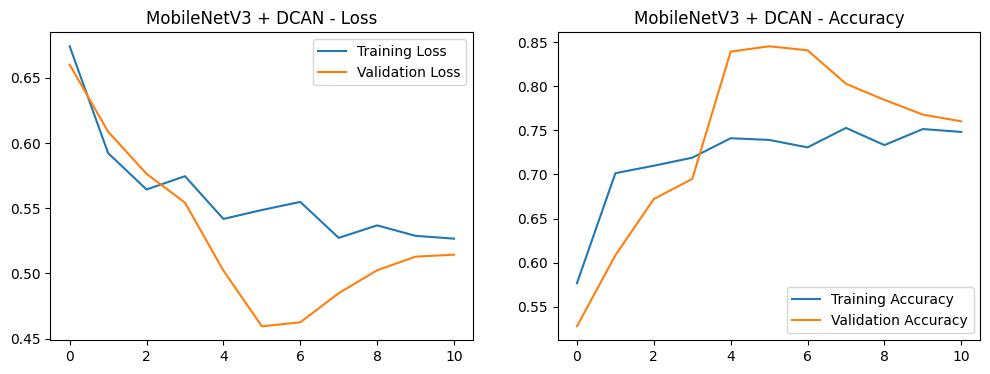

In [16]:
# Evaluate the model
model_with_dcan.load_weights('best_mobilenet_dcan_model.keras')
loss, accuracy = model_with_dcan.evaluate(test_generator)
print(f'MobileNetV3 with DCAN Test Accuracy: {accuracy:.2f}')

# Function to plot loss and accuracy curves
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.show()

# Plot training history
plot_history(history, 'MobileNetV3 + DCAN')

# Evaluate using confusion matrix and other metrics

# Evaluate the model
model_with_dcan.load_weights('best_mobilenet_dcan_model.keras')
loss, accuracy = model_with_dcan.evaluate(test_generator)
print(f'MobileNetV3 with DCAN Test Accuracy: {accuracy:.2f}')

# Function to plot loss and accuracy curves
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.show()

# Plot training history
plot_history(history, 'MobileNetV3 + DCAN')

# Evaluate using confusion matrix and other metrics
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score #Import confusion_matrix here so it has the correct scope

def evaluate_model(model, test_generator, class_labels):
    """
    Evaluate the model on test data and print various metrics.

    Parameters:
    - model: The trained Keras model.
    - test_generator: Keras ImageDataGenerator for test data.
    - class_labels: List of class labels.
    """
    # Get true labels and predictions
    y_true = test_generator.classes
    y_pred_prob = model.predict(test_generator, verbose=1)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Compute metrics
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = recall_score(y_true, y_pred)  # Recall
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    harmonic_mean = (2 * precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0


    # Print metrics
    print(f'Sensitivity (Recall): {sensitivity:.2f}')
    print(f'Specificity: {specificity:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print(f'Harmonic Mean of Precision and Recall: {harmonic_mean:.2f}')

    # Function to plot confusion matrix
def plot_confusion_matrix(model, test_generator, class_labels, title="Confusion Matrix"):
    """
    Plots the confusion matrix for a given model and test data.

    Parameters:
    - model: Trained model to evaluate.
    - test_generator: The generator for the test data.
    - class_labels: List of class labels for the confusion matrix axes.
    - title: Title of the plot.
    """
    !pip install seaborn
    import seaborn as sns #Import seaborn for heatmap

    # Predict the classes
    y_pred_prob = model.predict(test_generator, verbose=1)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Get the true labels
    y_true = test_generator.classes

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='cividis', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step
Sensitivity (Recall): 0.51
Specificity: 0.50
Precision: 0.49
F1 Score: 0.50
Harmonic Mean of Precision and Recall: 0.50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step


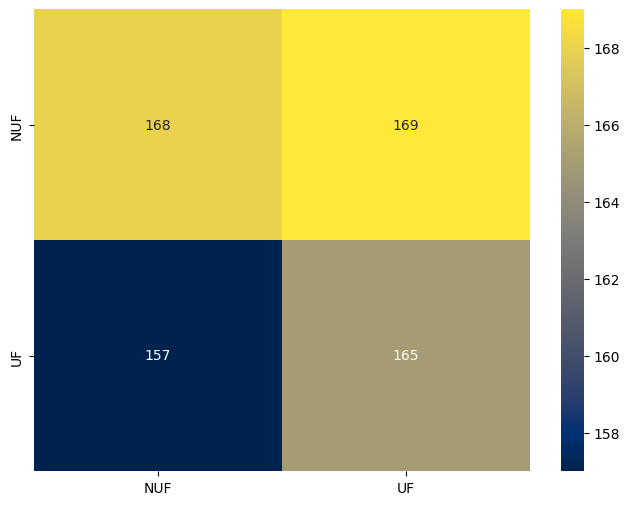

In [17]:
evaluate_model(model_with_dcan, test_generator, ['NUF', 'UF'])
plot_confusion_matrix(model_with_dcan, test_generator, ['NUF', 'UF'],title="MobileNet+GAN Confusion Matrix")